In [1]:
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare MNIST Data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [4]:
mnist_train = dsets.MNIST(root='data/', train=True, transform=transform, download=True)

In [5]:
batch_size = 100

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)

In [7]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

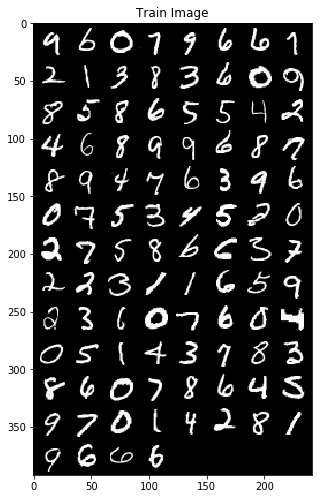

In [10]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

# Define Model

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride = 2, padding = 1), 
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2)
        )
        
        self.label_layer = nn.Sequential(
            nn.Linear(10, 256)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 7 * 7 + 256, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, label):
        out = self.discriminator(x)
        out_img = out.view(-1, 64 * 7 * 7)
        out_label = self.label_layer(label)
        
        out = self.fc_layer(torch.cat([out_img, out_label], dim = 1))
        return out

In [12]:
D = Discriminator()

In [14]:
D(torch.rand(100, 1, 28, 28),torch.rand(100, 10)).shape

torch.Size([100, 1])

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.latent_layer = nn.Sequential(
            nn.Linear(100, 256)
        )
        
        self.label_layer = nn.Sequential(
            nn.Linear(10, 256)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(256 + 256, 64 * 7 * 7)
        )
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 4, stride = 2, padding = 1),
            nn.Tanh()
        )
        
    def forward(self, z, label):
        out_z = self.latent_layer(z)
        out_label = self.label_layer(label)
        
        out = self.fc_layer(torch.cat([out_z, out_label], dim = 1))
        out = out.view(-1, 64, 7, 7)
        out = self.generator(out)
        return out

In [16]:
G = Generator()

In [17]:
G(torch.rand(100, 100), torch.rand(100, 10)).shape

torch.Size([100, 1, 28, 28])

# Train Model

In [18]:
def gan_loss(x, target_is_real):
    loss = nn.BCELoss()
    
    if target_is_real:
        target_tensor = torch.ones(batch_size, 1)
    else:
        target_tensor = torch.zeros(batch_size, 1)
        
    return loss(x, target_tensor)

In [19]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)

In [20]:
num_epochs = 20

In [21]:
one_hot_labels = torch.eye(10)

In [ ]:
for epoch in range(num_epochs):
    total_batch = len(mnist_train) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        labels = one_hot_labels[labels]
        
        prob_real = D(images, labels)
        D_loss_real = gan_loss(prob_real, True)
        
        z = torch.randn((batch_size, 100))
        fake_images = G(z, labels)
        
        prob_fake = D(fake_images, labels)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = D_loss_real + D_loss_fake
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        z = torch.randn((batch_size, 100))
        fake_images = G(z, labels)
        
        prob_fake = D(fake_images, labels)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.item(), G_loss.item()))

Epoch [1/20], lter [100/600], D_Loss: 0.1743, G_Loss: 4.7072


In [ ]:
G.eval()

for i in range(10):
    z = torch.randn((5, 100))
    images = G(z, one_hot_labels[[i] * 5])
    imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Test Image")